In [2]:
import sys
sys.path.append("..")
import os

import lauetools.LaueTools.IOimagefile as IOimage
print(IOimage)

Missing fabio module. Please install it if you need open some tiff images from the sCMOS camera
LaueToolsProjectFolder ..\lauetools\LaueTools
you are using python 3
<module 'lauetools.LaueTools.IOimagefile' from '..\\lauetools\\LaueTools\\IOimagefile.py'>


In [3]:
filename="140_S027_C090.TIFF"
dirname="../XRD_images/2nd_saving/"

x=IOimage.readCCDimage(filename=filename,CCDLabel='TIFF Format',dirname=dirname)

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...


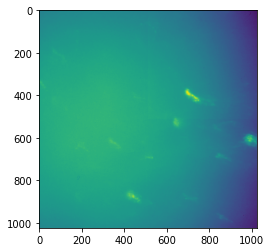

[[6233. 6298. 6270. ... 2188. 2222. 2273.]
 [6311. 6390. 6433. ... 2213. 2148. 2246.]
 [6469. 6463. 6435. ... 2257. 2201. 2258.]
 ...
 [6785. 6843. 7069. ... 2431. 2320. 2376.]
 [6965. 6939. 7042. ... 2358. 2303. 2437.]
 [7225. 7102. 6961. ... 2447. 2409. 2358.]]


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(np.log(x[0]))

plt.show()

im=x[0].astype(np.float32)
#im=im/im.max()
print(im)

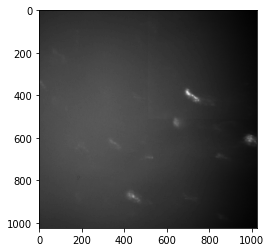

In [5]:
mu=im.mean()
sig=im.std()


im=(im-mu)/sig

u,s,vt=np.linalg.svd(im)
k=100

im_= np.dot(np.dot(u[:, :k], np.eye(k) * s[: k]), vt[:k, :])
plt.imshow(im_,cmap='gray')

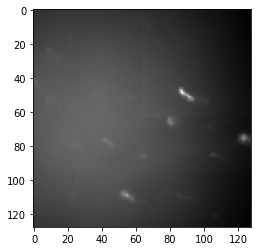

In [6]:
im_ = im.reshape(128, 8, 128,8).mean(-1).mean(1)
plt.imshow(im_,cmap='gray')

[-1042.2961      419.12173     750.30664   ...     1.6727116   -15.116644
    -7.236413 ]


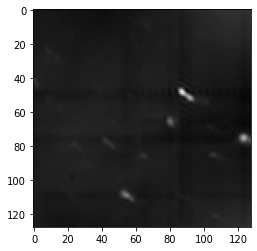

In [7]:
from scipy import fft

def reduce(im, sx, sy, lp, hp):
    SX, SY = im.shape
    im_ = im.reshape(sx, SX // sx, sy,SY // sy).mean(-1).mean(1)
    #ss=cv2.dct(im_)
    ss=fft.dctn(im_)
    ss[:lp, :] = 0.
    ss[:, :lp] = 0.
    ss[hp:, :] = 0.
    ss[:, hp:] = 0.
    #return cv2.idct(ss), ss[lp: hp, lp: hp].ravel()
    return fft.idctn(ss), ss[lp: hp, lp: hp].ravel()

x=reduce(im,128,128,1,65)
plt.imshow(x[0],cmap='gray')
print(np.array(x[1]))

(64, 146, 4096)


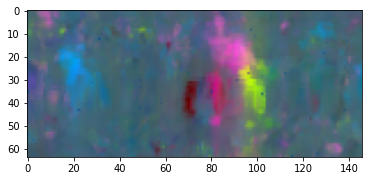

In [8]:
features=np.load('features4096.npy')

print(features.shape)

#features=features[:,:64,:]
#features=features.reshape((64*64,4096))

features=features.reshape((64*146,4096))

def scale(x0):
    min_,max_=x0.min(),x0.max()
    x=np.zeros(x0.shape)
    for i in range(x.shape[0]):
        x[i]=(x0[i]-min_)/(max_-min_)
    return x

#ss=np.zeros((128,128))
#ss[1:65,1:65]=features[:,6].reshape((64,64))
#plt.imshow(cv2.idct(ss),cmap='gray')


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nc=3
pca = PCA(n_components=nc, svd_solver='randomized')

pca_features=pca.fit_transform(features)#components_

im=np.zeros(pca_features.shape)
im[:,0]=scale(pca_features[:,0])
im[:,1]=scale(pca_features[:,1])
im[:,2]=scale(pca_features[:,2])
im=im.reshape((64,146,3))
#im=im.reshape((64,64,3))

plt.imshow(im)

In [9]:
from sklearn.decomposition import KernelPCA

transformer = KernelPCA(n_components=7, kernel='linear')
X_transformed = transformer.fit_transform(features)

(4096,)


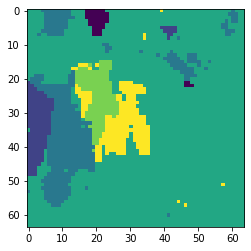

In [17]:
nc=250
pca = PCA(n_components=nc, svd_solver='randomized')

pca_features=pca.fit_transform(features)#components_

labels = KMeans(n_clusters=6, init='k-means++').fit_predict(features)
print(labels.shape)
grains=np.array(labels).reshape((64,64))
plt.imshow(grains)

In [28]:
nc=3
pca = PCA(n_components=nc, svd_solver='randomized')

pca_features=pca.fit_transform(features)#components_

from sklearn.cluster import AffinityPropagation


af = AffinityPropagation(preference=-50).fit(pca_features)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

colors=np.random.uniform(size=(n_clusters_,3))

print(n_clusters_)

print(labels.shape)

labels=labels.reshape((64,146))
im=np.zeros(tuple(list(labels.shape)+[3]))

for i in range(64):
    for j in range(146):
        im[i,j]=colors[labels[i,j]]
            

plt.imshow(im)

/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


0
(9344,)


/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


IndexError: index -1 is out of bounds for axis 0 with size 0

In [30]:
for nc in range(4,102,2):
    pca = PCA(n_components=nc, svd_solver='randomized')
    pca_features=pca.fit_transform(features)#components_
    af = AffinityPropagation(preference=-50).fit(pca_features)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters_ = len(cluster_centers_indices)
    labels=labels.reshape((64,146))
    np.save("%i"%nc,labels)


/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/s

/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  

/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  

/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "
/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  

/usr/local/lib/python3.8/dist-packages/scikit_learn-0.24.dev0-py3.8-linux-x86_64.egg/sklearn/cluster/_affinity_propagation.py:243: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn("Affinity propagation did not converge, this model "


In [20]:
"""
ns=[]
for nc in range(4,102,2):
    labels=np.load("%i.npy"%nc)
    ns.append(len(np.unique(labels)))
plt.plot(range(4,102,2),ns,'r.')
print(ns)
"""

labels=np.load("4.npy")
n_clusters_ = len(np.unique(labels))
colors=np.random.uniform(size=(n_clusters_,3))

print(n_clusters_)

print(labels.shape)

labels=labels.reshape((64,146))
im=np.zeros(tuple(list(labels.shape)+[3]))

for i in range(64):
    for j in range(146):
        im[i,j]=colors[labels[i,j]]
        #im[i,j]=np.array([0,0,0],dtype=np.uint64)
plt.imsave("4.tiff", im)





107
(64, 146)


In [21]:
labels=np.load("22.npy")
n_clusters_ = len(np.unique(labels))
colors=np.random.uniform(size=(n_clusters_,3))

print(n_clusters_)

print(labels.shape)

labels=labels.reshape((64,146))
im=np.zeros(tuple(list(labels.shape)+[3]))

for i in range(64):
    for j in range(146):
        im[i,j]=colors[labels[i,j]]
            

plt.imsave("22.tiff", im)


659
(64, 146)


(9344, 4096)


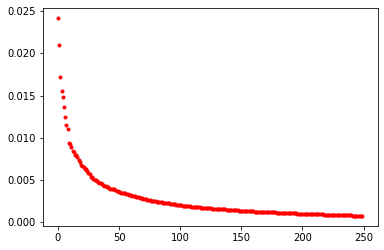

In [33]:
features=np.load('features4096.npy')
#print(features)
features=features.reshape((64*146,4096))

#ss=np.zeros((128,128))
#ss[1:65,1:65]=features[:,6].reshape((64,64))
#plt.imshow(cv2.idct(ss),cmap='gray')


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nc=250
pca = PCA(n_components=nc, svd_solver='randomized')
#pca.fit(features)

print(features.shape)
#print(pca.fit(features))

pca_features=pca.fit_transform(features)#components_
#rint(pca_features.shape)

plt.plot(np.arange(nc), pca.explained_variance_ratio_,'r.')
#plt.plot(np.arange(nc), pca.explained_variance_,'r.')


In [14]:
print(features.shape)
print(pca_features.shape)

labels = KMeans(n_clusters=590, random_state=170).fit_predict(features)
print(labels.shape)
grains=np.array(labels).reshape((64,146))
plt.imshow(grains)

(9344, 4096)
(9344, 250)


KeyboardInterrupt: 

[ 13  13  13 ...  41 112 112]


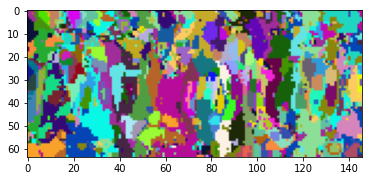

In [25]:
n_clusters_=120
colors=np.random.uniform

estimator=KMeans(n_clusters=n_clusters_,init='k-means++')
labels = estimator.fit_predict(pca_features)
print(labels)
colors=np.random.uniform(size=(n_clusters_,3))
grains=np.array(labels).reshape((64,146))

im=np.zeros(tuple(list(grains.shape)+[3]))

for i in range(64):
    for j in range(146):
        im[i,j]=colors[grains[i,j]]

plt.imshow(im)


[144 144 144 ... 150 216 216]


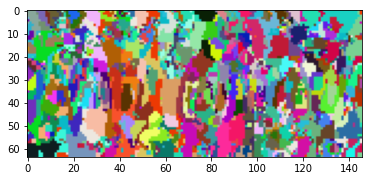

In [26]:
n_clusters_=240
colors=np.random.uniform

estimator=KMeans(n_clusters=n_clusters_,init='k-means++')
labels = estimator.fit_predict(pca_features)
print(labels)
colors=np.random.uniform(size=(n_clusters_,3))
grains=np.array(labels).reshape((64,146))

im=np.zeros(tuple(list(grains.shape)+[3]))

for i in range(64):
    for j in range(146):
        im[i,j]=colors[grains[i,j]]

plt.imshow(im)


In [13]:
print(pca_features.shape)

(9344, 250)


In [12]:
estimator=KMeans(n_clusters=590,init=pca.components_,n_init=1)
labels = estimator.fit_predict(pca_features)
print(labels)
grains=np.array(labels).reshape((64,146))
plt.imshow(grains)
plt.colorbar()

ValueError: The shape of the initial centers (250, 4096) does not match the number of clusters 590.

590


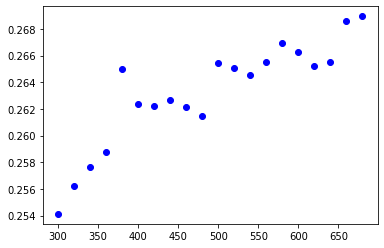

In [11]:
from sklearn import metrics
print(range(30,600,20)[-1])

#m=np.zeros((len(range(30,300,10))))
x=np.array(range(300,700,20))
sil=np.zeros(x.shape)
cal_har=np.zeros(x.shape)

for i in range(x.shape[0]):
    estimator=KMeans(n_clusters=x[i])
    labels = estimator.fit_predict(pca_features)
    sil[i]=metrics.silhouette_score(pca_features, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=len(labels))
    cal_har[i]=metrics.calinski_harabasz_score(pca_features, estimator.labels_)
plt.plot(x,sil,'bo')

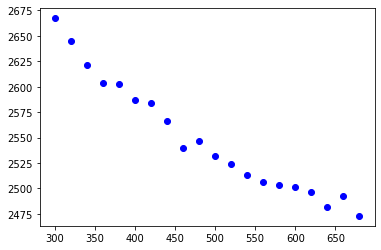

In [12]:
plt.plot(x,cal_har,'bo')

In [59]:
from time import time

n_digits=50
sample_size=300

data=pca_features

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)



k-means++	5.74s	1039593	0.712	0.652	0.681	0.483	0.670	0.003
random   	3.49s	1048925	0.689	0.629	0.658	0.417	0.646	0.009
PCA-based	0.51s	1050377	0.654	0.562	0.605	0.272	0.592	-0.037


In [6]:
features=np.load('features.npy')
#print(features)
features=features.reshape((64*146,1024))

from sklearn.decomposition import KernelPCA
#X, _ = load_digits(return_X_y=True)
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
#transformer = KernelPCA(n_components=7, kernel='linear')
X_transformed = kpca.fit_transform(features)
print(X_transformed)

[[-1.662688041947531e-04 -1.601686258234627e-04 -1.785035148648642e-04
  ...  4.835260978893936e-19 -1.897614334764881e-18
   5.457606634679029e-17]
 [-1.662688041911660e-04 -1.601686258218585e-04 -1.785035148658266e-04
  ... -2.323708381298024e-15  2.146773792173704e-15
   8.105528297288158e-17]
 [-1.662688042066897e-04 -1.601686257984825e-04 -1.785035149981646e-04
  ...  2.069086479037481e-14 -9.640036470839175e-15
  -3.215021698168313e-15]
 ...
 [-1.662688041946618e-04 -1.601686258233097e-04 -1.785035148647728e-04
  ...  2.259536763189092e-17  1.386093283003744e-16
   6.816224314392260e-17]
 [-1.662688041946616e-04 -1.601686258233099e-04 -1.785035148647729e-04
  ...  2.258486227050329e-17  1.385673578099389e-16
   6.823802399871839e-17]
 [-1.662688041946616e-04 -1.601686258233099e-04 -1.785035148647729e-04
  ...  2.264001270160612e-17  1.385673576097956e-16
   6.824538520296370e-17]]


In [7]:
np.save("rbf_10",features)

In [36]:
s_range=range(64)
c_range=range(146)

features=np.zeros((64,146,4096))

for i in s_range:
    for j in c_range:
        if (i >= 100):
            str_i=str(i)
        else:
            if (i >= 10):
                str_i='0'+str(i)
            else:
                str_i='00'+str(i)
        if (j >= 100):
            str_j=str(j)
        else:
            if (j >= 10):
                str_j='0'+str(j)
            else:
                str_j='00'+str(j)
        path="../XRD_images/2nd_saving/"+"140_S"+str_i+"_C"+str_j+".TIFF"
        im=IOimage.readCCDimage(path,CCDLabel='TIFF Format')[0]
        if (im.mean() > 1e-10):
            im=(im-im.mean())/im.std()
        features[i,j]=reduce(im,128,128,1,65)[1]
np.save('features4096',features)

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
---

CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...
CCDLabel in readCCDimage TIFF Format
----> Using libtiff...


In [ ]:
import pywt
coeffs = pywt.dwt2(im, 'haar')
print(coeffs[0].shape)
print(len(coeffs[1]))

a,b=coeffs
im.shape
coeffs = pywt.wavedec(im, 'bior3.7', level = 100)
coeffs[0].shape
#返回结果为level+1个数字，第一个数组为逼近系数数组，后面的依次是细节系数数组



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

input_shape = (1024,1024,1)
#input_shape = (128,128,1)
model = Sequential()
## Feature Extraction
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

""""""
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'))
#                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
""""""
model.add(Dense(256, activation='relu'))


model.summary()

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()

sess = tf.Session()

print(im.shape)
x=tf.convert_to_tensor(im.reshape([1,1024,1024,1]),dtype=tf.float32)
#x = tf.ones((1,1024,1024,1))
print(x)
#sess.run(x)


In [ ]:
y=model(x)

#sess.run(y)

In [ ]:
print(y)

In [ ]:
print(sess.run(y))